## Titanic Data with using Shapash.
Shapash is a Python library which aims to make machine learning interpretable and understandabl. 

I will briefly explain how to use and what we can do with Shapash. With using Shapash, it is possible to analyze data interactively. 
Through this notebook, I will briefly explain how to use Shapash with Titanic data.The Image of Shapash is below.

The documents about Shapash: https://shapash.readthedocs.io/en/latest/

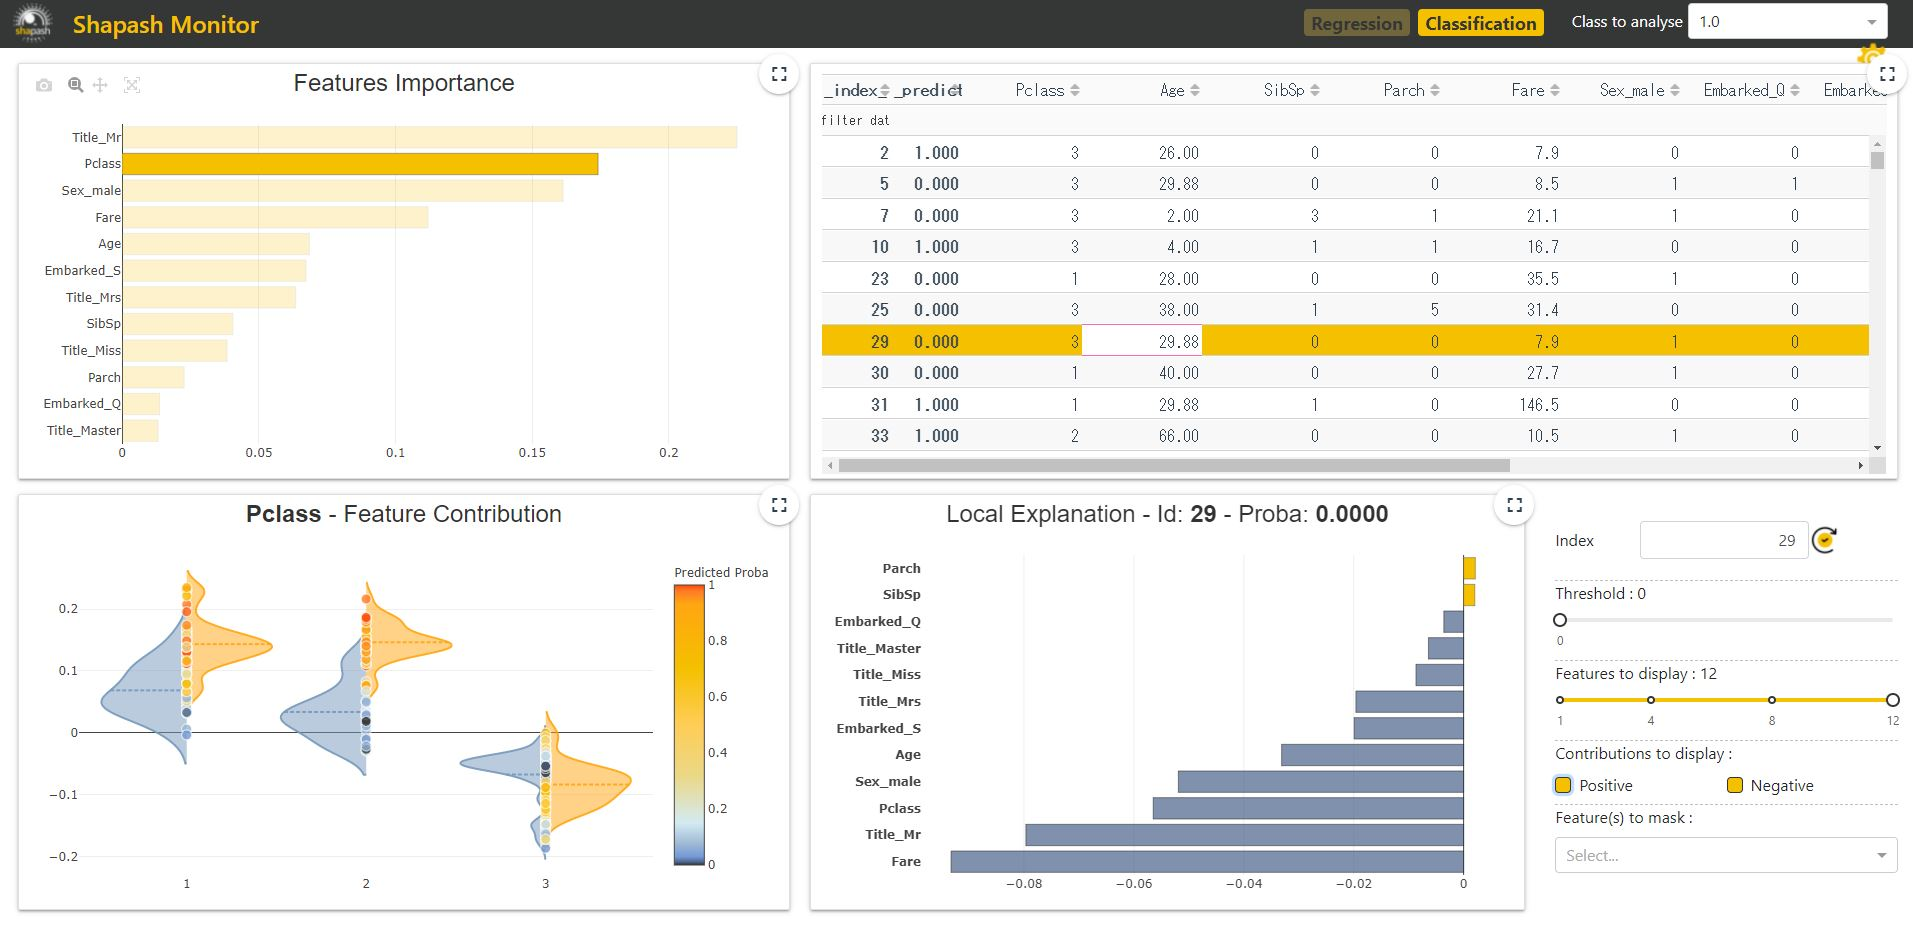

In [1]:
from IPython.display import Image
file_name = "shapash.JPG"
Image(file_name)

### 1.Preprocessing
To analyze Titanic data with Shapash, briefly preprocess and prepare library.

In [2]:
# !pip install shapash

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

alldata = pd.concat([train, test],axis=0)

def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'
    
def replace_titles(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

alldata['Title'] = alldata['Name'].map(lambda x: get_title(x))
alldata['Title'] = alldata.apply(replace_titles, axis=1)

alldata=alldata.drop(["PassengerId","Name","Ticket","Cabin"],axis=1)
alldata=pd.get_dummies(alldata, drop_first=True) #To avoid Multicollinearity, add drop_first=True

alldata['Age'] = alldata['Age'].fillna(np.nanmean(alldata['Age']))
alldata['Fare'] = alldata['Fare'].fillna(np.nanmean(alldata['Fare']))

train = alldata.iloc[:train.shape[0],:]
test = alldata.iloc[train.shape[0]:,:]

target_col = "Survived"
feature_col = [col for col in alldata.columns if col not in target_col]

X_df = train[feature_col]
y_df = train[target_col]

Breafly check the correlation between features by heatmap.

Text(0.5, 1.0, 'Heatmap\xa0of all the Features')

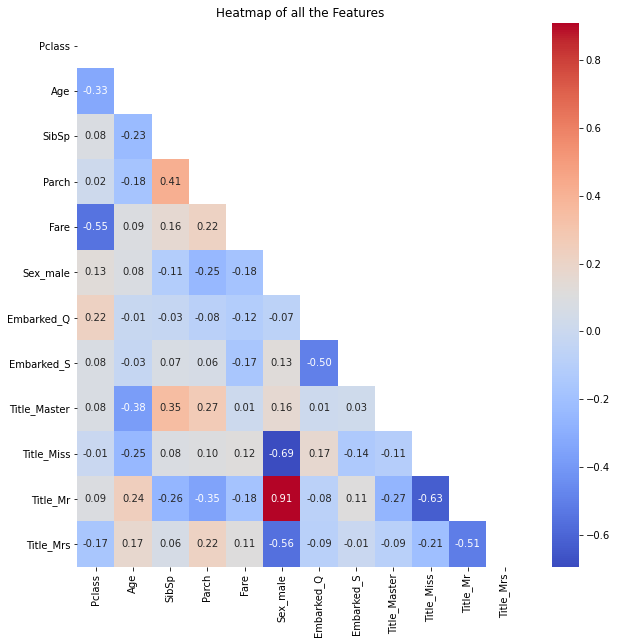

In [5]:
import seaborn as sns
plt.subplots(figsize=(10,10))
matrix = np.triu(X_df.corr())
sns.heatmap(X_df.corr(), annot=True, mask=matrix, cmap='coolwarm',fmt='.2f')
plt.title("Heatmap of all the Features")

Since corellation between Title_Mr. and Sex_male is high, drop the feature "Sex_male"

In [6]:
feature_col = [col for col in alldata.columns if col not in [target_col,"Sex_male"]]

You need to hand over features with dictionary format to Shapash

In [7]:
Titanic_dict = dict(zip(feature_col,feature_col))
Titanic_dict

{'Pclass': 'Pclass',
 'Age': 'Age',
 'SibSp': 'SibSp',
 'Parch': 'Parch',
 'Fare': 'Fare',
 'Embarked_Q': 'Embarked_Q',
 'Embarked_S': 'Embarked_S',
 'Title_Master': 'Title_Master',
 'Title_Miss': 'Title_Miss',
 'Title_Mr': 'Title_Mr',
 'Title_Mrs': 'Title_Mrs'}

In [8]:
from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df)

X_df=encoder.transform(X_df)

### 2.Create Model

In [9]:
model = RandomForestClassifier(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42)
regressor = model.fit(X_train,y_train)
print('Accuracy:',model.score(X_test,y_test))
y_pred = pd.DataFrame(regressor.predict(X_test),columns=['pred'],index=X_test.index)

Accuracy: 0.8022388059701493


### 3. Use Shapash

In [10]:
from shapash.explainer.smart_explainer import SmartExplainer
xpl = SmartExplainer(features_dict=Titanic_dict)
# xpl = SmartExplainer(features_dict=house_dict)

xpl.compile(
    x=X_test,
    model=regressor,
    preprocessing=encoder, # Optional: compile step can use inverse_transform method
    y_pred=y_pred # Optional
)
app = xpl.run_app()

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:Your Shapash application run on http://DESKTOPTOMO:8050/


Backend: Shap TreeExplainer
Dash is running on http://0.0.0.0:8050/



INFO:root:Use the method .kill() to down your app.
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/



 * Serving Flask app "shapash.webapp.smart_app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://0.0.0.0:8050/ (Press CTRL+C to quit)


### 4. Finish application
Finishing application, typ app.kill()

In [11]:
app.kill()